Some of the code is reused from @Yassinghouzam. Check it out and consider upvoting his notebook! https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
import pickle

In [4]:
df = pd.read_csv("Phishing_Legitimate_full.csv")

In [13]:
df.shape

(10000, 50)

In [14]:
#df['Abnormal_URL'].value_counts() HttpsInHostname
#df.columns

Index(['id', 'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
       'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
       'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperl

In [15]:
display(df.head())

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [5]:
df.drop('id', axis = 1, inplace = True)
df.drop('HttpsInHostname', axis=1, inplace=True)

## Exploration

The percentages of the class values.

c:\Users\t58\miniconda3\envs\ml_ven\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\t58\miniconda3\envs\ml_ven\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\t58\miniconda3\envs\ml_ven\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


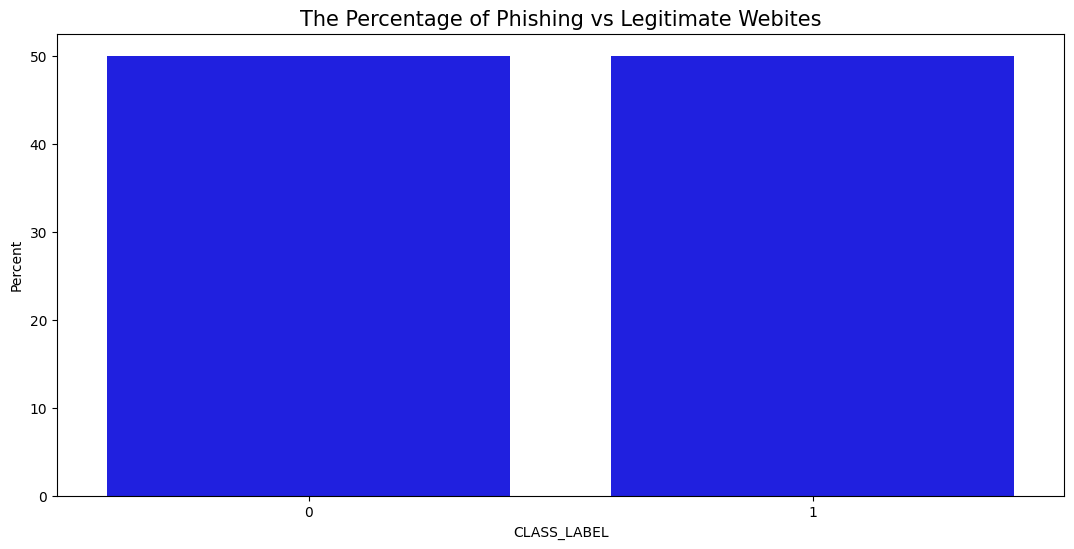

In [17]:
plt.figure(figsize=(13, 6))
ax = sns.barplot(x="CLASS_LABEL", y="CLASS_LABEL", data=df, estimator=lambda x: len(x) / len(df) * 100, color = 'Blue')
ax.set(ylabel="Percent");
ax.set_title('The Percentage of Phishing vs Legitimate Webites', size = 15);
plt.savefig('resultpercentageplot_v1.png', dpi=300, bbox_inches='tight');

Correlation between all the variables.

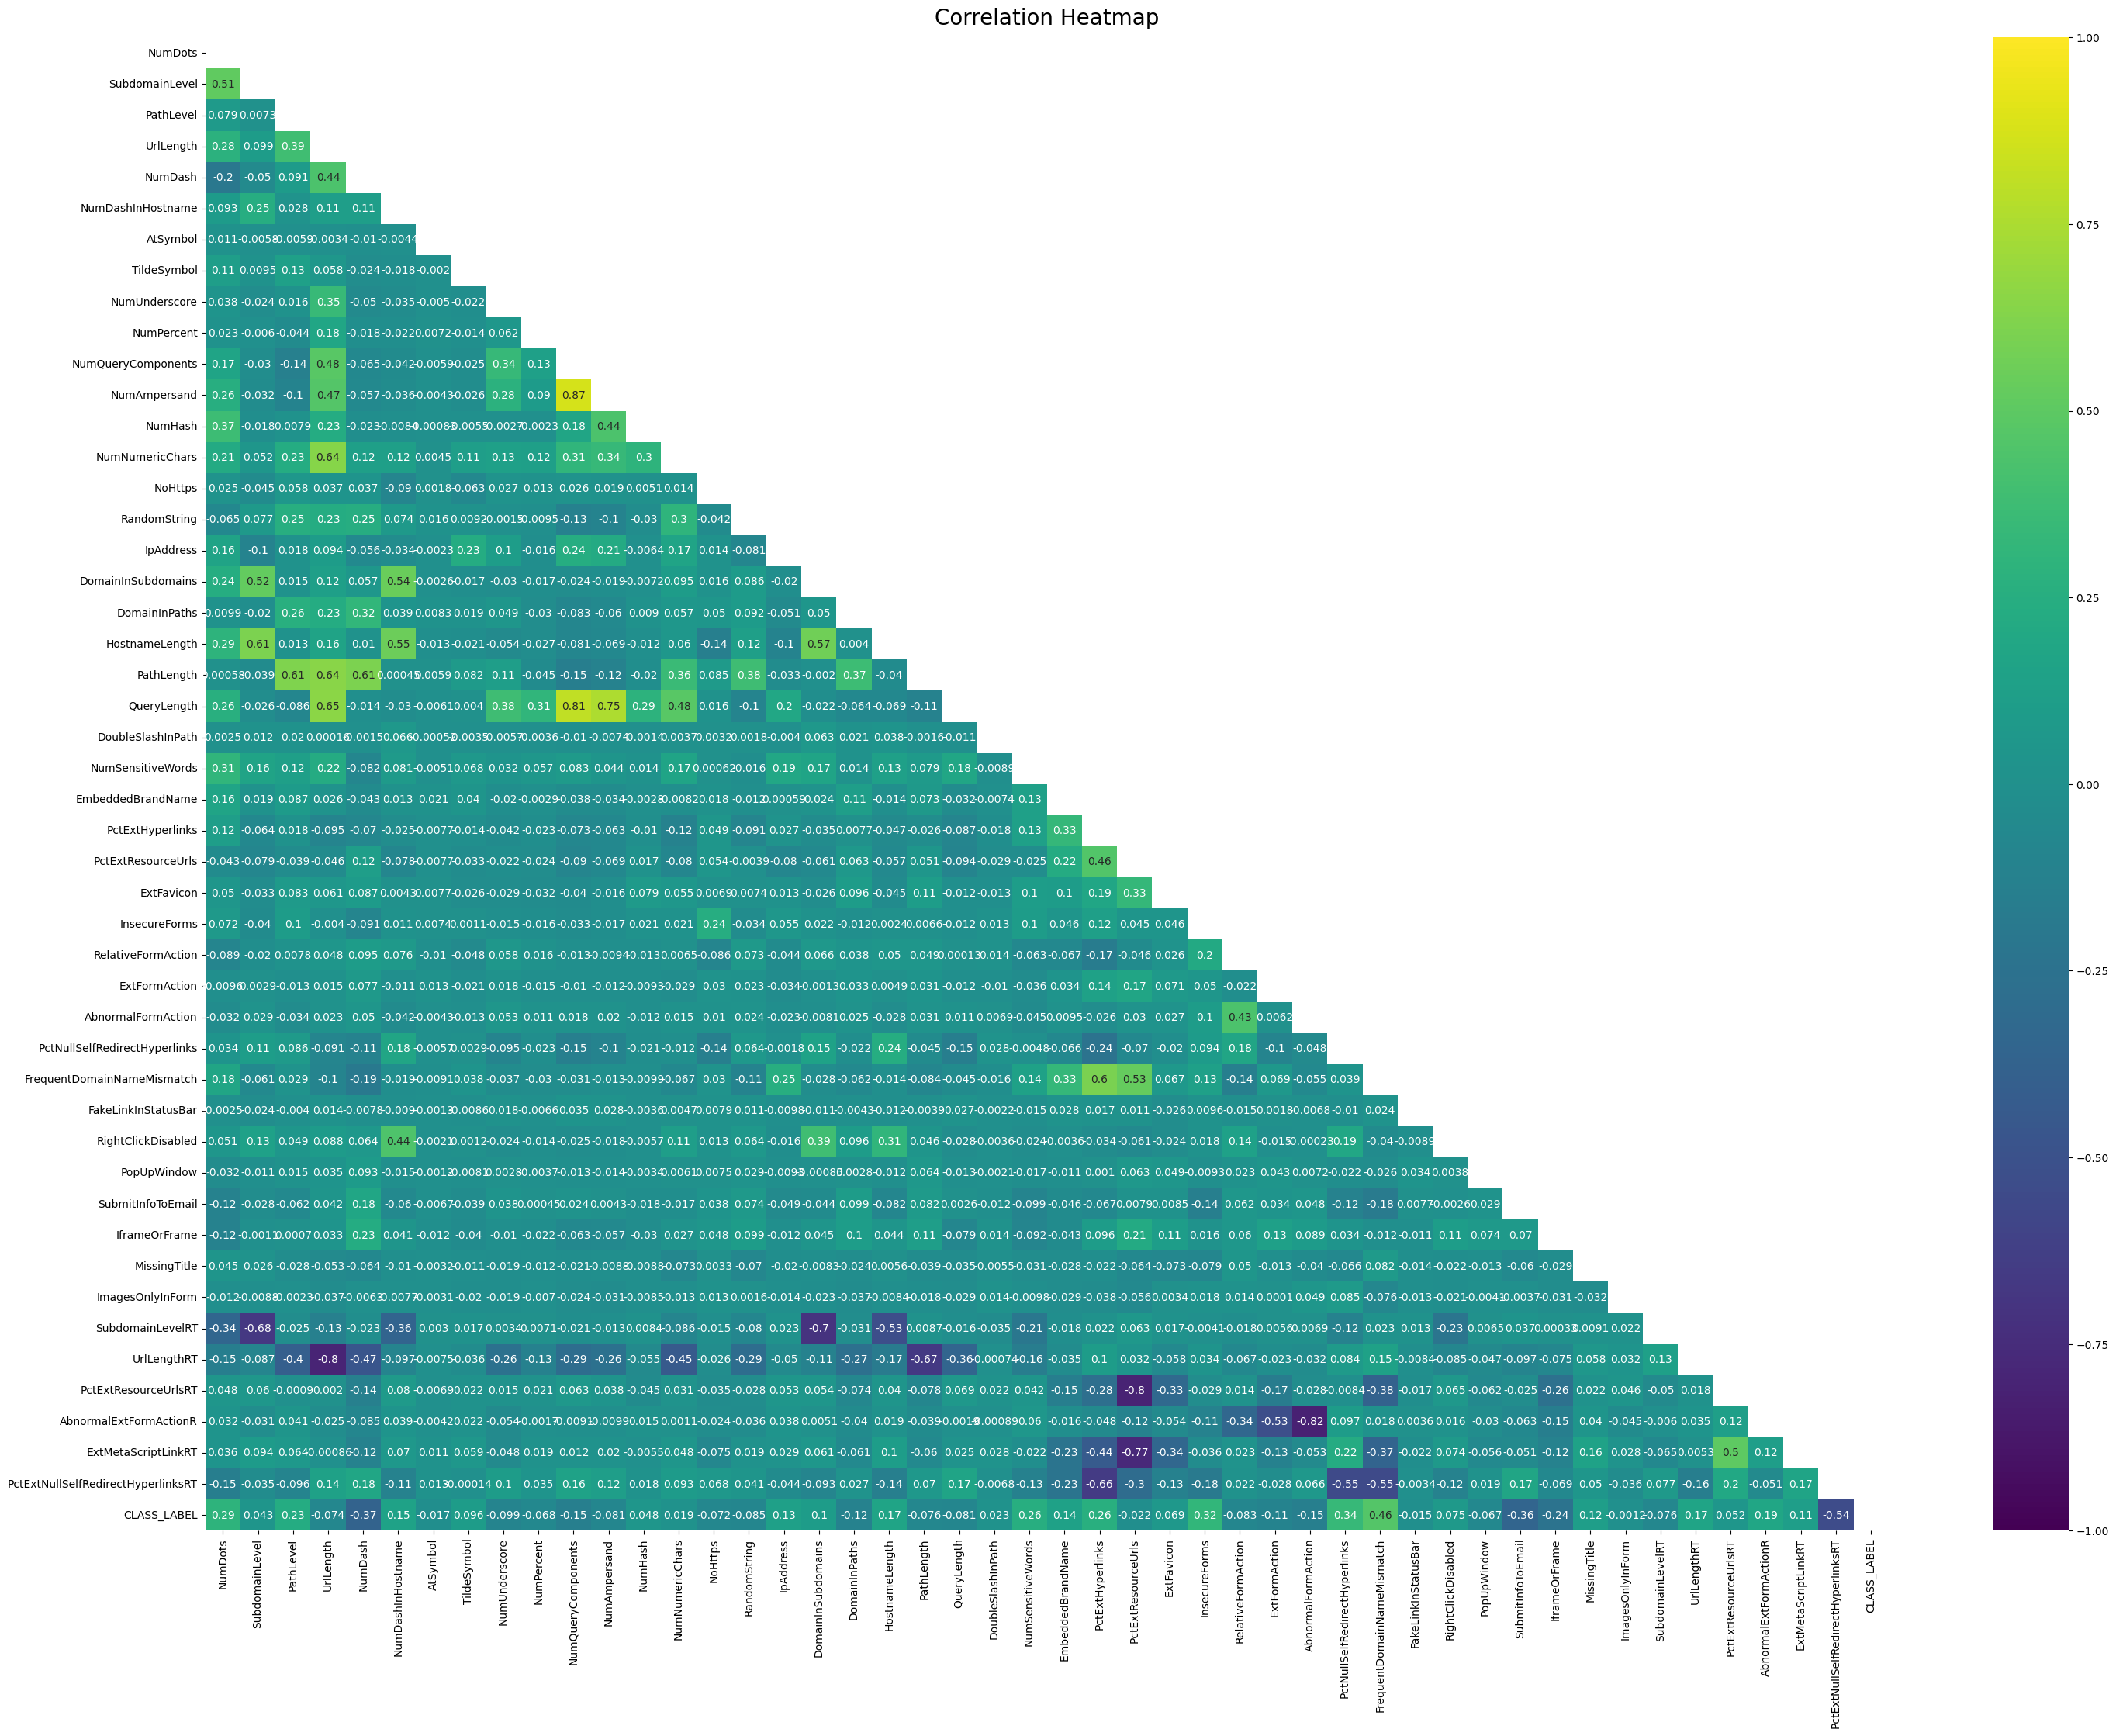

In [18]:
plt.figure(figsize=(35, 25))
corr = df.corr()
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool_))
heatmap = sns.heatmap(corr, mask = mask, vmin=-1, vmax=1, annot=True, cmap = 'viridis')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);
plt.savefig('heatmap_v1.png', dpi=300, bbox_inches='tight')

Variables with the highest correlation with the target variable.

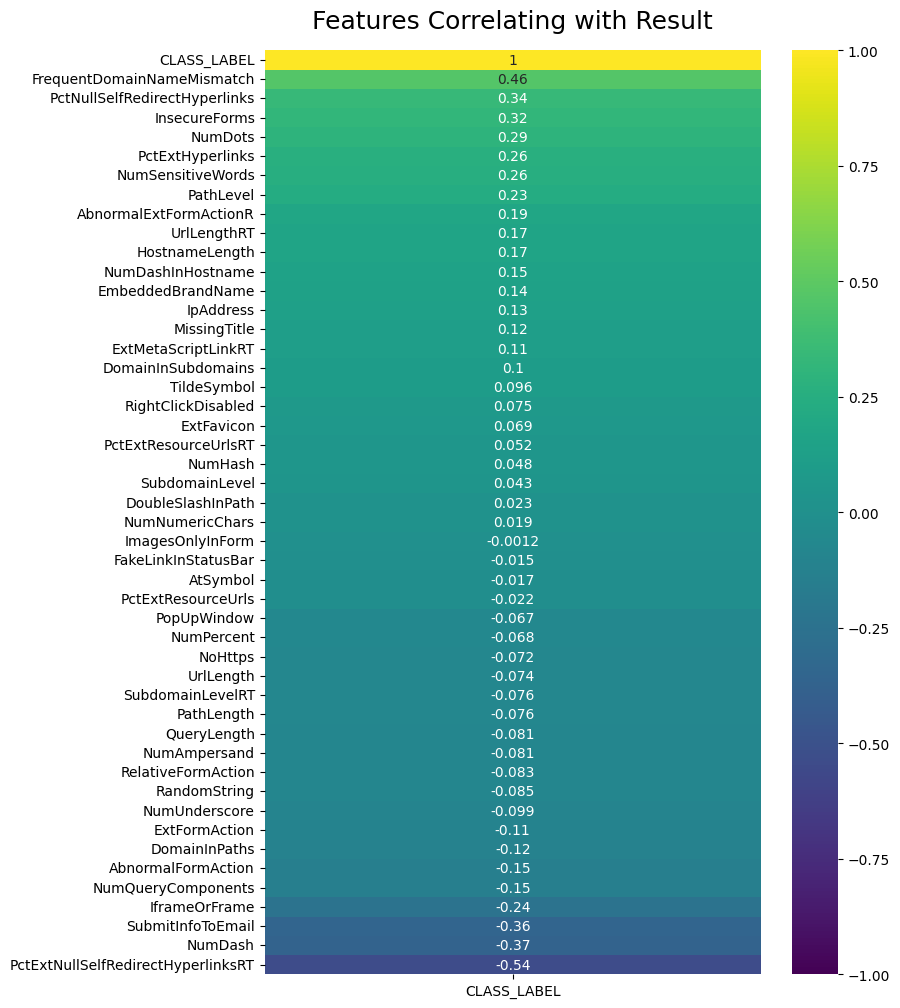

In [19]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['CLASS_LABEL']].sort_values(by='CLASS_LABEL', ascending=False), vmin=-1, vmax=1, annot=True, cmap = 'viridis')
heatmap.set_title('Features Correlating with Result', fontdict={'fontsize':18}, pad=16);
plt.savefig('heatmapfeaturecorr_v1.png', dpi=300, bbox_inches='tight')

## Ensembling Model

In [6]:
#Splitting Data
X = df.drop('CLASS_LABEL', axis = 1)
y = df['CLASS_LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Cross Validate Models

We will compare 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.



* SVC
* Decision Tree
* AdaBoost
* XGBoost
* Random Forest
* Extra Trees
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis


In [7]:
kfold = StratifiedKFold(n_splits=10)

In [8]:
random_state = 42

classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

In [9]:
cv_res.sort_values(by = 'CrossValMeans', ascending = False)
# from the following we'll choose RandomForest, ExtraTrees, NN, AdaBoost and decusion trees as our classifiers.

,CrossValMeans,CrossValerrors,Algorithm
3,0.982687,0.004438,RandomForest
4,0.981642,0.004862,ExtraTrees
5,0.977015,0.004823,GradientBoosting
1,0.965821,0.006206,DecisionTree
2,0.964925,0.010238,AdaBoost
6,0.963284,0.007847,MultipleLayerPerceptron
9,0.938806,0.007669,LinearDiscriminantAnalysis
8,0.934627,0.009482,LogisticRegression
0,0.844627,0.012042,SVC
7,NaN,NaN,KNeighboors


### Cross validation on the choosen models best parameters

In [10]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {
              "max_features": [3, 10, 20],
              "n_estimators" :[100,300, 500],
              "criterion": ["gini", "entropy"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 18 candidates, totalling 180 fits


0.982089552238806

In [11]:
gsRFC.best_params_

{'criterion': 'gini', 'max_features': 3, 'n_estimators': 500}

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "n_estimators" :[100,300, 400],
              "criterion": ["gini", "entropy"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

In [ ]:
gsExtC.best_params_

In [ ]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[10, 50, 100, 150],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_
print(gsadaDTC.best_score_)

In [ ]:
gsadaDTC.best_params_

In [ ]:
# # Multilayer Neural Network
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(300,200,100), (200,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [ ]:
clf.best_score_

In [ ]:
nn_best = clf.best_estimator_

In [ ]:
# Decision Tree
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : range(1,50),
              'min_samples_split': range(2,15),
              'min_samples_leaf': range(1,10),
              'criterion' :['gini', 'entropy']
             }

tree_clas = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, verbose=True)
grid_search.fit(X_train, y_train)

dt_best = grid_search.best_estimator_

print(grid_search.best_params_)
print(grid_search.best_score_)

### Plot learning curves

In [ ]:
def plot_learning_curve(estimator, title, X, y, save, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    #plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig(save, dpi=300, bbox_inches='tight')
    return plt

g1 = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold, save = 'RFLearningPlot')
g2 = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold, save = 'ETLearningPlot')
g3 = plot_learning_curve(nn_best,"NN learning curves",X_train,y_train,cv=kfold, save = 'NNLearningPlot')
g4 = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold, save = 'AdaLearningPlot')
g5 = plot_learning_curve(dt_best,"DT learning curves",X_train,y_train,cv=kfold, save = 'DTLearningPlot')

Decision tree had the highest tendency to overfit.

### Voting Classifier

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('nn', nn_best), ('adac',ada_best),('dt',dt_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)
y_pred = votingC.predict(X_test)

pickle.dump(votingC, open('model.sav', 'wb'))

# to read the model later
# model = pickle.load(open('model', 'rb'))
# res = model.score(X_test, y_test)
# res

### Plot Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

In [ ]:
data = confusion_matrix(y_test, y_pred, normalize = 'all')
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.title("Confusion Matrix Heat Map\n")
plt.savefig('ConfusionMatrix', dpi=300, bbox_inches='tight')

In [ ]:
print(f'{votingC} Training Score: {votingC.score(X_train, y_train)}')
print(f'{votingC} Testing Score: {votingC.score(X_test, y_test)}')
print()
print(classification_report(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))

In [ ]:
target_names = ['Phishing', 'Legitamite']
print(classification_report(y_test, y_pred, target_names=target_names))